In [2]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import shapely.geometry
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [3]:
server='skyriver'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
HUC8_IDs = ['14010001', '14080101'] ## get list of HUC8 IDs
ds_lst = []
## loop through all HUC8s
for i, HUC8_ID in enumerate(HUC8_IDs):
    print(i, HUC8_ID)
    ## load watershed trajectories
    path_to_data = '/home/dnash/comet_data/preprocessed/UCRB_trajectories/latest/'
    fname = path_to_data + 'PRISM_HUC8_{0}.nc'.format(HUC8_ID)
    ERA5 = xr.open_dataset(fname)
    ds_lst.append(ERA5)
    
## concat ds_lst along HUC8 index
ds = xr.concat(ds_lst, pd.Index(HUC8_IDs, name="HUC8"))
ds

0 14010001
1 14080101


<xarray.Dataset>
Dimensions:             (start_date: 28, index: 72, HUC8: 2)
Coordinates:
  * start_date          (start_date) datetime64[ns] 2022-10-13 ... 2023-03-23
  * index               (index) int64 0 1 2 3 4 5 6 7 ... 65 66 67 68 69 70 71
    lat                 (HUC8, start_date, index) float64 nan nan ... nan nan
    lon                 (HUC8, start_date, index) float64 nan nan ... nan nan
    time                (HUC8, start_date, index) datetime64[ns] NaT ... 2023...
    start_lev           float64 650.0
    grid                <U6 'center'
  * HUC8                (HUC8) object '14010001' '14080101'
Data variables: (12/17)
    IVT                 (HUC8, start_date, index) float64 nan nan ... nan nan
    uIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    vIVT                (HUC8, start_date, index) float64 nan nan ... nan nan
    IWV                 (HUC8, start_date, index) float64 nan nan ... nan nan
    level               (HUC8, start_date, index) float64 nan nan ... nan nan
    q                   (HUC8, start_date, index) float64 nan nan ... nan nan
    ...                  ...
    ar_scale_strict     (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar_strict           (HUC8, start_date) float64 nan 1.0 0.0 ... nan 1.0 0.0
    coastal_IVT_strict  (HUC8, start_date) float64 nan 262.5 ... 283.4 270.7
    ar_scale            (HUC8, start_date) float64 nan nan nan ... nan nan nan
    ar                  (HUC8, start_date) float64 nan 1.0 0.0 ... nan 1.0 1.0
    coastal_IVT         (HUC8, start_date) float64 nan 576.1 ... 375.3 594.3
Attributes:
    Conventions:  CF-1/0

In [26]:
tmp = ds.sel(HUC8='14010001')
ts = pd.to_datetime(tmp.start_date.values[0]) 
ts.strftime('%b-%d')

'Oct-13'

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


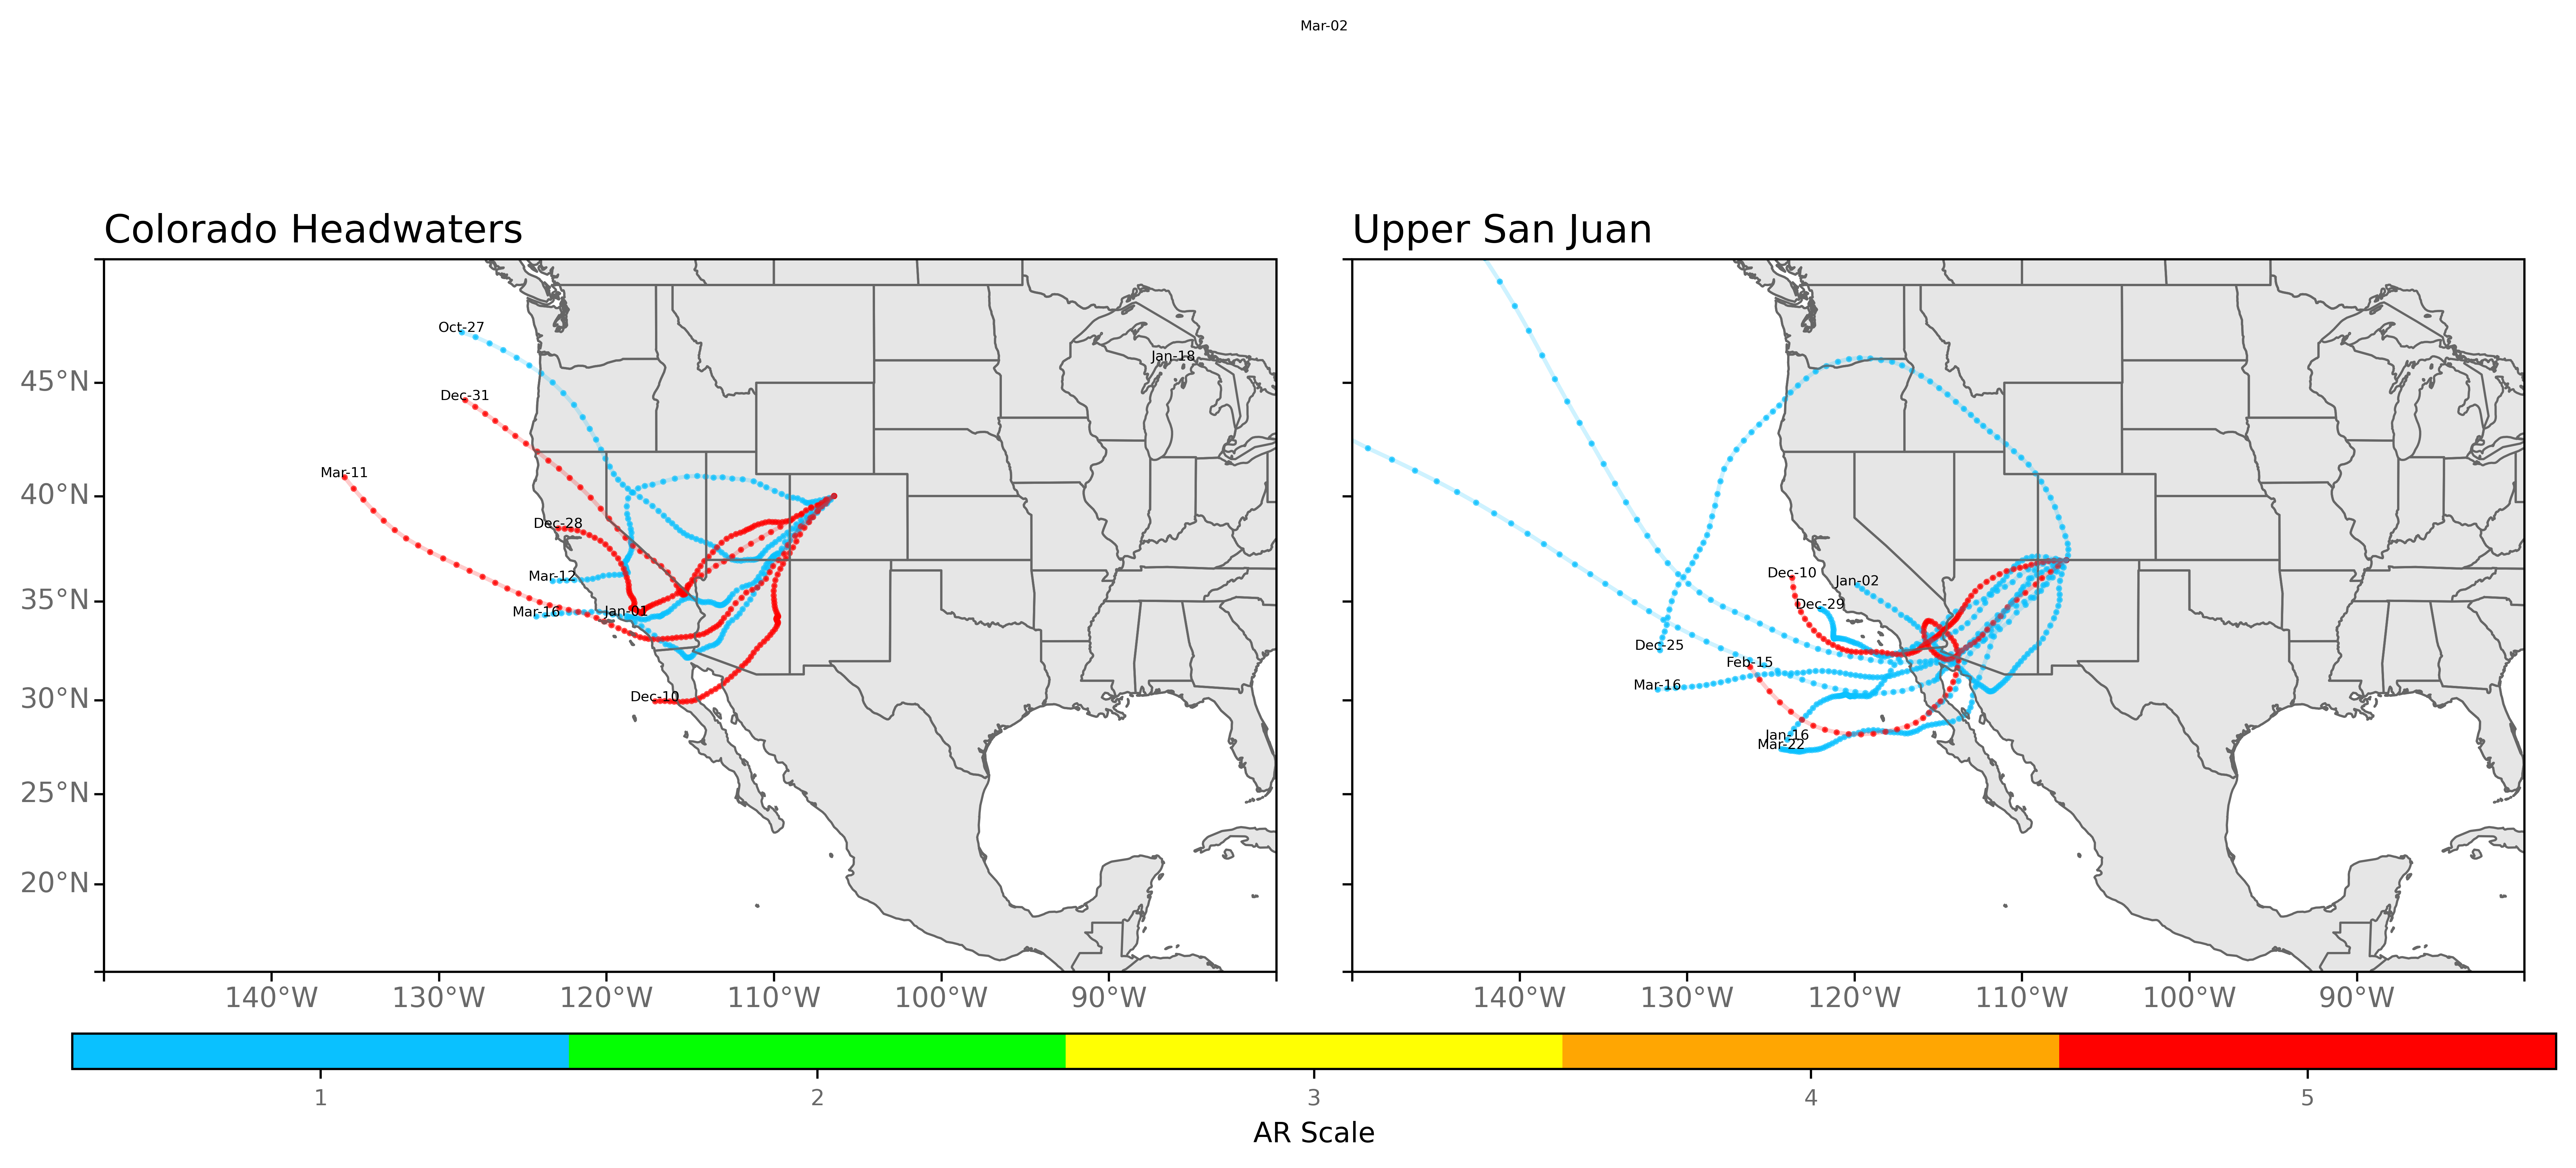

In [28]:
nrows = 3
ncols = 2

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in

ext = [-150., -80., 15., 50.] 

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 0.05], width_ratios = [1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(16.0, 5.25))
fig.dpi = 600
fname = path_to_figs + 'ARScale_WY2023'
fmt = 'png'

############################
### PLOT AR SCALE VALUES ###
############################
plt_lbl = ['NDJFMA', 'MJJASO']
colors = ['#0ac1ff', '#04ff03', '#ffff03', '#ffa602', '#ff0100']
left_lats = [True, False]
basin_lst = ['Colorado Headwaters', 'Upper San Juan']

for i, HUC8_val in enumerate(HUC8_IDs):

    ax = fig.add_subplot(gs[0, i], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=left_lats[i], right_lats=False, bottom_lons=True)
    ax.set_extent(ext, datacrs)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

    ax.set_title(basin_lst[i], loc='left', fontsize=14)
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)

    tmp = ds.sel(HUC8=HUC8_val)
    ## Loop through AR scale values
    AR = tmp.where(tmp.ar == 1, drop=True)
    nevents = len(AR.start_date)
    ## LOOP THROUGH TRAJECTORIES
    for m in range(nevents):
        data = AR.isel(start_date=m)
        y_lst = data.lat.values
        x_lst = data.lon.values
        ax.plot(x_lst, y_lst, c=colors[0], transform=datacrs, alpha=0.2)
        cf = ax.scatter(x_lst, y_lst, c=colors[0], marker='.', transform=datacrs, alpha=0.7, s=6)
        ts = pd.to_datetime(data.start_date.values) 
        z = ts.strftime('%b-%d')
        ax.annotate(z, # this is the text
                   (x_lst[-1],y_lst[-1]), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center', # horizontal alignment can be left, right or center
                    xycoords=transform,
                    zorder=200,
                    fontsize=5)
        
        
    AR = tmp.where(tmp.ar == 0, drop=True)
    nevents = len(AR.start_date)
    ## LOOP THROUGH TRAJECTORIES
    for m in range(nevents):
        data = AR.isel(start_date=m)
        y_lst = data.lat.values
        x_lst = data.lon.values
        ax.plot(x_lst, y_lst, c=colors[-1], transform=datacrs, alpha=0.2)
        cf = ax.scatter(x_lst, y_lst, c=colors[-1], marker='.', transform=datacrs, alpha=0.7, s=6)
        ts = pd.to_datetime(data.start_date.values) 
        z = ts.strftime('%b-%d')
        ax.annotate(z, # this is the text
                   (x_lst[-1],y_lst[-1]), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center', # horizontal alignment can be left, right or center
                    xycoords=transform,
                    zorder=200,
                    fontsize=5)

# # Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
plot_arscale_cbar(cbax, orientation='horizontal')

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()